<img src="../images/mario_v_zelda.jpg" width="1920" height="1080">

Image credit: [thenerdstash.com](https://thenerdstash.com/clash-at-the-stash-1-the-mario-franchise-vs-the-zelda-franchise/)

## Which Nintendo franchise is more popular, Mario or Zelda?

Super Mario and The Legend of Zelda are two of the most popular gaming franchises in history. Nintendo fans often argue about which franchise is better. Of course, this all depends on your gaming preferences, but we may be able to determine which franchise is most popular among fans.

The purpose of this project is to analyze Nintendo's tweets to discover if tweets about Mario garner more favorites or retweets than tweets about The Legend of Zelda. We will accomplish this through simple permutation testing using the difference of the means as a test statistic.

### Import packages

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(64)

### Load data

The data was downloaded from the Twitter API. Twitter only allows 200 tweets per request, but I was able to make multiple requests in order to accumulate just under 2,500 tweets going back to December 2018. The data does not contain retweets, only original tweets from Nintendo of America's account.

In [5]:
# load data
nintendo = pd.read_csv('../data/Nintendo_tweets.csv', index_col=0)

# take a look at the data frame
nintendo.head()

,id,created_at,fav,rt,text
0,1299059620540035072,2020-08-27 19:02:03,1380,192,Discover a puzzling adventure as a lost ember ...
1,1299029126846787586,2020-08-27 17:00:53,1881,351,All aboard the caravan!\n\n#FinalFantasy Cryst...
2,1299014221829738498,2020-08-27 16:01:39,1464,141,"The Lore, Legends, and Heroes from Marvel have..."
3,1298999090429059076,2020-08-27 15:01:32,1713,157,The war to save Reality starts now! Drop into ...
4,1298788572263329792,2020-08-27 01:05:00,2912,385,🎶 Play to the beat of your own drum with 39 ne...


### Data Exploration

Let's see how much data we have, if the types of the data make sense and if there are any nulls in the data.

In [6]:
nintendo.shape[0]

2433

In [7]:
nintendo.dtypes

id             int64
created_at    object
fav            int64
rt             int64
text          object
dtype: object

In [8]:
nintendo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 5
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2433 non-null   int64 
 1   created_at  2433 non-null   object
 2   fav         2433 non-null   int64 
 3   rt          2433 non-null   int64 
 4   text        2433 non-null   object
dtypes: int64(3), object(2)
memory usage: 114.0+ KB


Alright, the data looks fine for our analysis. Let'a take a closer look at the favorite and retweet columns.

In [9]:
nintendo[['fav', 'rt']].describe()

,fav,rt
count,2433.000000,2433.000000
mean,5661.341143,1109.221537
std,12316.417899,3679.911568
min,240.000000,17.000000
25%,1379.000000,167.000000
50%,2533.000000,356.000000
75%,5692.000000,884.000000
max,350698.000000,123183.000000


Wow, looks like one tweet got over 350,000 favorites. Let's see what tweet was so popular.

In [10]:
print(nintendo[nintendo['fav'] == max(nintendo['fav'])]['text'].values)

['Nintendo fans, Reggie has a message for all of you. Please take a look. https://t.co/EAhaEl5oEJ']


Ah, this is when Reggie Fils-Aime, the previous president of Nintendo of America, announced his retirement. Reggie, or 'The Regginator' as he is lovingly called, is very popular among Nintendo fans, so I'm sure this tweet got a lot of reaction from Nintendo's followers.

Now, let's take a look at the ditribution of favorites and retweets.

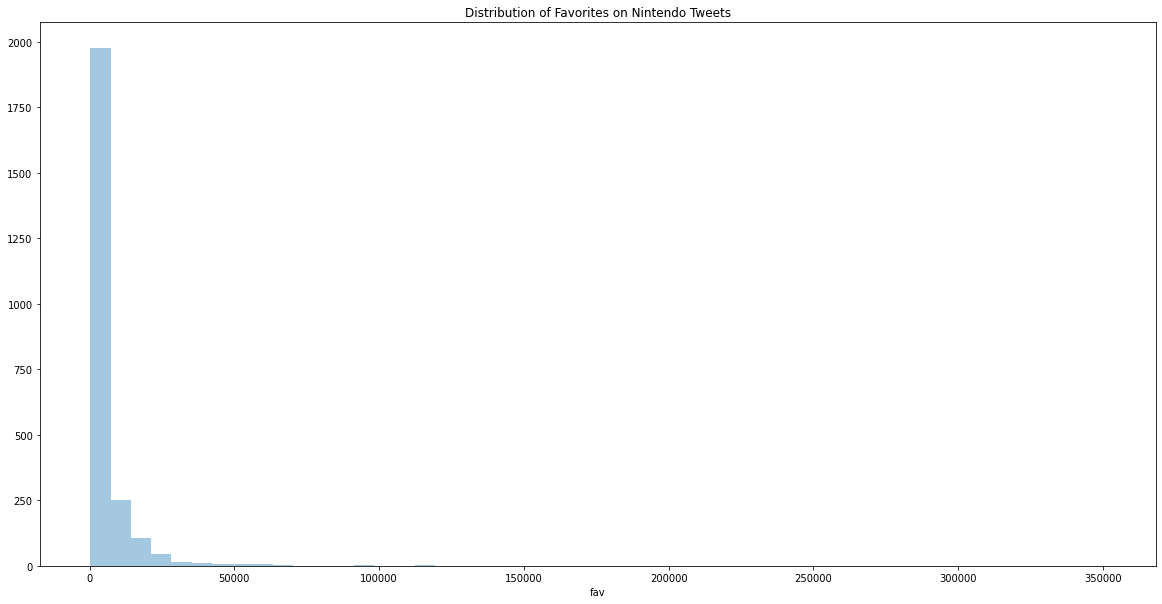

In [8]:
plt.figure(figsize=(20,10));
sns.distplot(nintendo['fav'], kde=False).set_title('Distribution of Favorites on Nintendo Tweets');
plt.show()

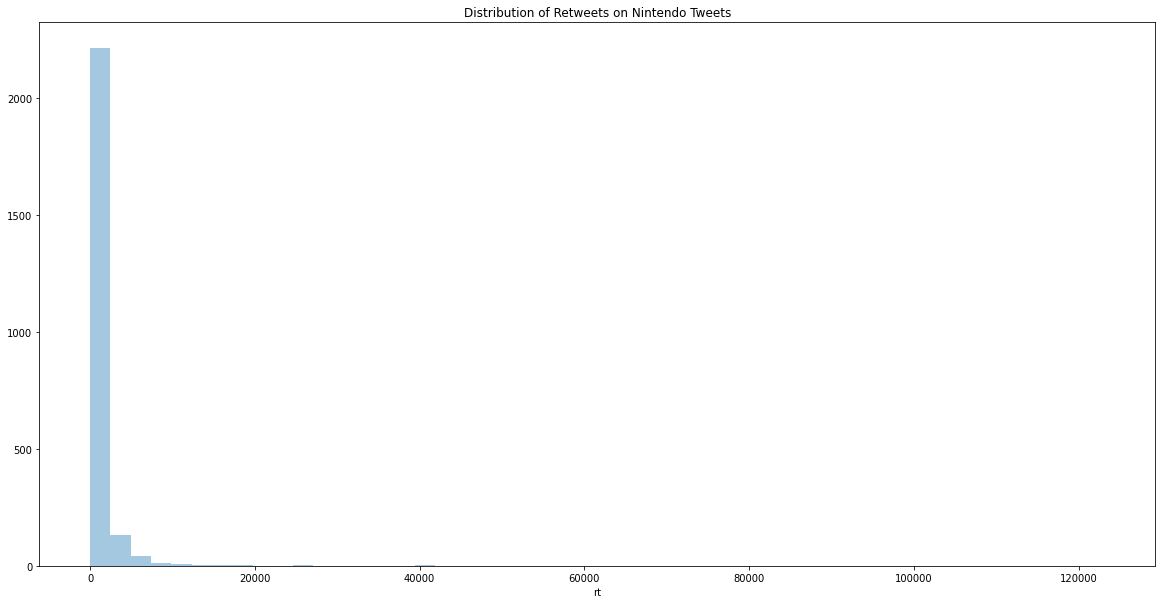

In [9]:
plt.figure(figsize=(20,10));
sns.distplot(nintendo['rt'], kde=False).set_title('Distribution of Retweets on Nintendo Tweets');
plt.show()

Both distributions are pretty skewed. There are a lot of tweets with a couple thousand favorites or less and very few with 5,000 favorites or more. In terms of the retweets, there are a lot of tweets with a few hundred likes and very few with over 1000 retweets.

## Filtering on Mario and The Legend of Zelda

Although the distributions of favorites and retweets are interesting, we are more concerned with the actual content of the tweets. We want to determine which tweets were about Mario and which were about The Legend of Zelda. An easy way to do this is to isolate hashtags in Nintendo's tweets. Let's write a function that extracts hashtags from Nintendo's tweeets and returns them in a list.

In [10]:
def extract_hastag(text):
    """
    Given an array of text strings, extract all hastags and return them in a list.
    """
    
    # Initialize an empty list to store hashtags
    hashtag_list = []
    
    # Loop through array
    for string in text:
        # Split the text by word
        for word in string.split():
            # check if the word starts with a #
            if word[0] == '#':
                # remove !, ., ? from end of hastag
                word = word.replace('!', '')
                word = word.replace('?', '')
                word = word.replace('.', '')
                word = word.replace(':', '')
                word = word.replace(',', '')
                # add hashtag to list
                hashtag_list.append(word)
    
    return hashtag_list

Now, let's use the function to see the most popular hashtags.

In [11]:
hashtags = pd.Series(extract_hastag(nintendo['text']))

In [12]:
hashtags.value_counts(sort=True)[:10]

#NintendoSwitch        799
#eShop                 127
#PokemonSwordShield    113
#SuperMarioMaker2      110
#AnimalCrossing        105
#Zelda                  94
#FireEmblem             93
#NintendoMinute         90
#SmashBrosUltimate      88
#FEHeroes               79
dtype: int64

The Nintendo Switch hastag is the unsurprisingly the most popular. This makes sense, as it's Nintendo's main console and any game they talk about will also involve talking about the Switch.

What is surprising to me is that a general Zelda hastag makes it into the top 10, but a general Super Mario hastag does not! Considering Mario is bascially Nintendo's mascot, I would've thought his hashtag would've been used more frequently.

Although extracting hastags was helpful, it seems tweets about Mario may not always use the #SuperMario hastag. Thus, we may want to simply isolate certain strings from the tweets. For the Mario franchise, we can probabaly use 'Mario' alone. For the Zelda franchise, we may need to add a few more like 'Zelda', 'Link', or 'Hyrule'.

Looking at the list of the Super Mario games [here](https://en.wikipedia.org/wiki/Super_Mario#Series), it looks like the word 'Mario' is in every title. The string 'Mario' should be enough.

Looking at the same for The Legend of Zelda [here](https://en.wikipedia.org/wiki/List_of_The_Legend_of_Zelda_media), it looks like 'Zelda' will do for the most part. However, it looks like a few titles only include 'Link' and 'Hyrule' so we will use these as well.

Let's create two new dataframes that only have tweets concerning the Mario or Zelda franchises by filtering tweet text on the above strings.

In [15]:
# Mario or Zelda
mario = nintendo[nintendo['text'].str.contains('Mario')]
zelda = nintendo[nintendo['text'].str.contains('Link') | 
                 nintendo['text'].str.contains('Zelda') | 
                 nintendo['text'].str.contains('Hyrule')]

In [16]:
mario.head()

,id,created_at,fav,rt,text
5,1298711843104411648,2020-08-26 20:00:06,2410,207,"A new Ninji Speedruns course, ""Big Shoes Gusti..."
54,1294393469952294913,2020-08-14 22:00:26,1072,89,Kit &amp; Krysta attempt expert level #PaperMa...
56,1293985603499864064,2020-08-13 18:59:43,329,19,NO PURCH. NEC. Must be US &amp; CAN res. age 1...
57,1293985602149392384,2020-08-13 18:59:43,1723,218,It’s almost time to tear up the track in the #...
60,1293608193659154432,2020-08-12 18:00:02,85512,9017,"Stay cool, Mario! https://t.co/xID5J1lmuH"


### Mario vs Zelda

In [17]:
mario.shape[0]

310

In [18]:
zelda.head()

,id,created_at,fav,rt,text
4,1298788572263329792,2020-08-27 01:05:00,2912,385,🎶 Play to the beat of your own drum with 39 ne...
128,1285228096518385666,2020-07-20 15:00:31,2699,419,A physical version of #CadenceOfHyrule – Crypt...
129,1285227777751494657,2020-07-20 14:59:15,5025,809,Keep stepping to the beat with new content for...
425,1253789339189829632,2020-04-24 20:54:07,912,85,Which of Link’s companions would you pick to b...
579,1236064014225948673,2020-03-06 23:00:00,1507,156,Which is the fastest way between two points in...


In [19]:
zelda.shape[0]

138

Just looking at the amount of tweets, Nintendo seems to mention Mario a bit more. Let's see how the average favorite counts compare.

In [20]:
mario_fav_mean = mario['fav'].mean()
zelda_fav_mean = zelda['fav'].mean()

print(f"Tweets about Mario receive an average of {mario_fav_mean:,.0f} favorites.")
print(f"Tweets about Zelda receive an average of {zelda_fav_mean:,.0f} favorites.")

Tweets about Mario receive an average of 6,982 favorites.
Tweets about Zelda receive an average of 6,978 favorites.


Mario actually gets a bit more favorites on average. What about retweets?

In [21]:
mario_rt_mean = mario['rt'].mean()
zelda_rt_mean = zelda['rt'].mean()

print(f"Tweets about Mario receive an average of {mario_rt_mean:.0f} retweets.")
print(f"Tweets about Zelda receive an average of {zelda_rt_mean:.0f} retweets.")

Tweets about Mario receive an average of 1316 retweets.
Tweets about Zelda receive an average of 1513 retweets.


Zelda wins here, but they are relatively close again. This is most likely due to chance, but let's do a permutation test to make sure. In order to do this, we will need a function that will create bootstrap replicates of the mean favorites and retweets. Let's write that function now.

In [22]:
# function that takes in a data array and creates n bootstrap replicates
def draw_bootstrap_reps(data, function, n=1):
    """
    Draw n bootstrap replicates from data using given function
    """
    # Initialize an empty array for storing replicates
    bs_replicates = np.empty(n)
    
    # Given a size n
    for i in range(n):
        # Generate a random sample with replacement from data
        bs_sample = np.random.choice(data, len(data))
        # create the replicate using the given function
        bs_replicates[i] = function(bs_sample)
    
    return bs_replicates

Let's make sure our function works by taking a large number of samples and plotting the distribution of means. If we take 10,000 bootstrap samples, we would expect the distribution to be approximately normal.

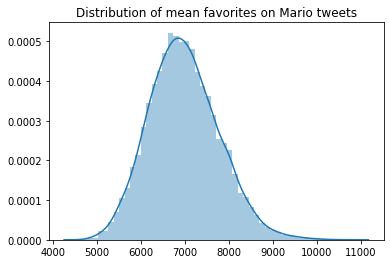

In [23]:
mario_fav_mean_replicates = draw_bootstrap_reps(mario['fav'], np.mean, 10000)

ax = sns.distplot(mario_fav_mean_replicates, kde=True).set_title("Distribution of mean favorites on Mario tweets");
plt.show()

It looks like the distribution of average favorites is roughly normal, with just a slightly longer right tail. We would expect the same to hold for tweets about Zelda.

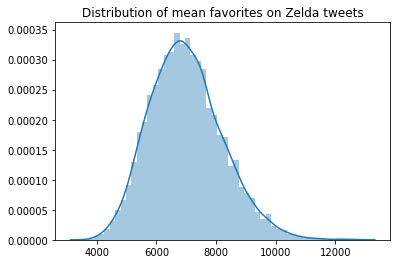

In [24]:
zelda_fav_mean_replicates = draw_bootstrap_reps(zelda['fav'], np.mean, 10000)

ax = sns.distplot(zelda_fav_mean_replicates, kde=True).set_title("Distribution of mean favorites on Zelda tweets");
plt.show()

The distribution for favorites on Zelda tweets looks very similar. Now, lets compute 95% confidence intervals from the bootstrap replicates.

In [25]:
mario_fav_95_ci = np.percentile(mario_fav_mean_replicates, [2.5, 97.5])
zelda_fav_95_ci = np.percentile(zelda_fav_mean_replicates, [2.5, 97.5])

print(f"95% CI for Mario favorites: ({mario_fav_95_ci[0]:0,.2f}, {mario_fav_95_ci[1]:,.2f})")
print(f"95% CI for Zelda favorites: ({zelda_fav_95_ci[0]:0,.2f}, {zelda_fav_95_ci[1]:,.2f})")

95% CI for Mario favorites: (5,537.71, 8,616.81)
95% CI for Zelda favorites: (4,884.24, 9,632.55)


Alright, there is pretty significant overlap between the confidence intervals. It is looking likely that the distributions are the same. To make it official, let's run a permutation test. First, we will write a function that will draw a permutation sample from two given datasets. The function, which will be called `permutation_sample`, will take two datasets, concatenate them together, shuffle them and then split them back up. We will need this later when we simulate many permutations.

In [26]:
def permutation_sample(data1, data2):
    """
    Given two (array-like) data sets, create a permutation sample
    """
    
    # Concatenate the datasets together
    data = np.concatenate((data1, data2))
    
    # 'Shuffle' the data
    shuffled = np.random.permutation(data)
    
    # Re-assign the data back as perm_sample_1 and perm_sample_2
    perm_sample_1 = shuffled[:len(data1)]
    perm_sample_2 = shuffled[len(data1):]
    
    return perm_sample_1, perm_sample_2

Awesome, we will now create another function that will generate permutation replicates. That is, given two sets of data, it will create a permutation and compute a statistic of interest as many times as we need.

In [27]:
def draw_permutation_replicates(data1, data2, function, n=1):
    """
    Generate n permutation replicates using given function
    """
    
    # Create an empty array to store replicates
    permutation_replicates = np.empty(n)
    
    for i in range(n):
        # Create permutation sample
        permuation_sample_1, permutation_sample_2 = permutation_sample(data1, data2)
        
        # Compute test statistic and store in permutation_replicates array
        permutation_replicates[i] = function(permuation_sample_1, permutation_sample_2)
        
    return permutation_replicates

Ok, we just need one more function. Since we are concerned with the difference of the means of the favorites, we will write a small function that computes the difference of means.

In [28]:
def mean_difference(data1, data2):
    """
    Compute the difference of means of two (array-like) datasets
    """
    
    return np.mean(data1) - np.mean(data2)

Ok, now we are ready to set up a permutation test. In this test, our test statistic will be the difference of the means between favorites for Mario and favorites for Zelda. Let's compute the actual difference we observed.

In [29]:
fav_observed_difference = mean_difference(mario['fav'], zelda['fav'])

print(f"The observed difference in means for favorites was {fav_observed_difference:,.2f}")

The observed difference in means for favorites was 3.71


Time to run the permutation test. For this test, the null hypothesis is the the mean difference should be 0. That is to say, the distributions of favorites for Mario and Zelda are the same. If this is the case, we can simply draw many permutation replicates and calculate what percentage of them had a difference as exterme as the one we saw. If only a small percentage of the replicates were as extreme, we can conclude that the distributions are different. Let's draw the permutation replicates and compute the p-value.

In [30]:
# Draw 100,000 permutation replicates of the difference of the means from the two datasets
permutation_replicates = draw_permutation_replicates(mario['fav'], zelda['fav'], mean_difference, 100000)

# Compute p-value
p = np.sum(permutation_replicates >= fav_observed_difference) / len(permutation_replicates)

print(f"p-value: {p}")

p-value: 0.51149


Wow, just over half of the samples saw a difference as large as we observed. Thus, we cannot reject the null hypothesis. The distibution of average favorites on Mario and Zelda tweets may come from the same distribution.

What about retweets though? Let's quickly run a similar test for the retweets.

In [31]:
rt_observed_difference = mean_difference(zelda['rt'], mario['rt'])

print(f"The observed difference in means for retweets was {rt_observed_difference:,.2f}")

The observed difference in means for retweets was 197.31


In [32]:
# Draw 100,000 permutation replicates of the difference in means
rt_permutation_replicates = draw_permutation_replicates(zelda['rt'], mario['rt'], mean_difference, 100000)

# Compute p-value
rt_p = np.sum(permutation_replicates >= rt_observed_difference) / len(permutation_replicates)

print(f"p-value: {rt_p}")

p-value: 0.46002


Well, it looks like our p-value is almost as large as in the case of favorites. Thus, we still cannot separate these two distributions. It may be the case that these two franchises are equally popular among fans and thus see similar distributions of retweets and favorites when Nintendo tweets about them.

However, do tweets about these franchises see more likes and retweets than the rest of Nintendo's tweets? Again, we can run a quick permutation test.

In [33]:
# Combine Mario and Zelda tweets
mario_zelda = mario.append(zelda, ignore_index=True).drop_duplicates()

not_mario_zelda = nintendo[~nintendo['id'].isin(mario_zelda['id'])]

In [34]:
# Calculate the observed difference of favorites
fav_observed_diff = mean_difference(mario_zelda['fav'], not_mario_zelda['fav'])
print(f"Observed difference of average favorites: {fav_observed_diff:,.2f}\n")

# Draw 100,000 permutation reolicates of the difference in means
fav_permutations = draw_permutation_replicates(mario_zelda['fav'], not_mario_zelda['fav'], mean_difference, 100000)

# Compute p-value
fav_p = np.sum(fav_permutations >= fav_observed_diff) / len(fav_permutations)
print(f"p-value: {fav_p}")

Observed difference of average favorites: 1,720.38

p-value: 0.0097


Aha! Less than 1% of the permutation samples saw a difference as extreme as we originally saw. We can conclude that the distributions of average favorites for tweets about Mario and Zelda is larger than that of Nintendo's tweets about other topics.

Let's see if the same is true about retweets.

In [35]:
# Calculate the observed difference of favorites
rt_observed_diff = mean_difference(mario_zelda['rt'], not_mario_zelda['rt'])
print(f"Observed difference of average retweets: {rt_observed_diff:,.2f}\n")

# Draw 100,000 permutation reolicates of the difference in means
rt_permutations = draw_permutation_replicates(mario_zelda['rt'], not_mario_zelda['rt'], mean_difference, 100000)

# Compute p-value
rt_p = np.sum(rt_permutations >= rt_observed_diff) / len(rt_permutations)
print(f"p-value: {rt_p}")

Observed difference of average retweets: 351.20

p-value: 0.05696


Our p-value here is just slightly over 5%. Although this means the result is not 'statistically' significant. It seems as though we observed a difference that is rather rare.

## Conclusion

The purpose of this project was to find out which Nintendo franchise, Mario of The Legend of Zelda, is more popular using favorites and retweets on Nintendo's tweets as a proxy for popularity. Using permutation tests, we were unable to determine if the distributions of average favorites and retweets for Mario and Zelda were different. Thus, we were not able to say which franchise was more popular based on those statistics. 

However, we also ran a permutation test of Mario and Zelda tweets against all of Nintendo's other tweets. In terms of favorties, the results were statistically significant. The results for retweets were not statistically significant at the 0.05 level, but the p-value was only just above 5%. Therefore, we can pretty safely conclude that although Mario and The Legend of Zelda may be equally popular, they are definetly among the most popular things Nintendo tweets about.

Favorites, which I believe are now called 'likes', and retweets are usually ways people express what twitter content they like or agree with, although this is not always the case. Thus, favorites and retweets seemed like a good measure of how popular the tweets were. However, is there a better metric? It is often said that if replies to a tweet vastly outnumber the amount of likes or retweets then users consider the content of the tweet to be poor. Unfortunately, twitter does not have an easy way to determine how many replies a tweet received. However, there are workarounds and using them will be the goal of my next project.